### Let's build the simplest possible autoencoder

Referenced from: https://blog.keras.io/building-autoencoders-in-keras.html 

In [8]:
import keras
from keras import layers

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [11]:
# This is the size of our encoded representations
encoding_dim = 32

# This is our input image
input_img = keras.Input(shape=(784,)) # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

Let's also create a separate encoder model:

In [12]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

As well as the decoder model:



In [13]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

Now let's train our autoencoder to reconstruct MNIST digits.

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adam optimizer:

In [14]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's prepare our input data. We're using MNIST digits, and we're discarding the labels (since we're only interested in encoding/decoding the input images).

In [15]:
from keras.datasets import mnist
import numpy as np 
(x_train, _), (x_test, _) = mnist.load_data()

We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.



In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Now let's train our autoencoder for 50 epochs:



In [17]:
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.2742 - val_loss: 0.1901
Epoch 2/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1711 - val_loss: 0.1538
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1444 - val_loss: 0.1336
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1282 - val_loss: 0.1207
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1177 - val_loss: 0.1124
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1109 - val_loss: 0.1070
Epoch 7/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1061 - val_loss: 0.1029
Epoch 8/50
235/235 [==============================] - 1s 2ms/step - loss: 0.1027 - val_loss: 0.1001
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0978
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0960

After 50 epochs, the autoencoder seems to reach a stable train/validation loss value of about 0.09. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [18]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 256us/step


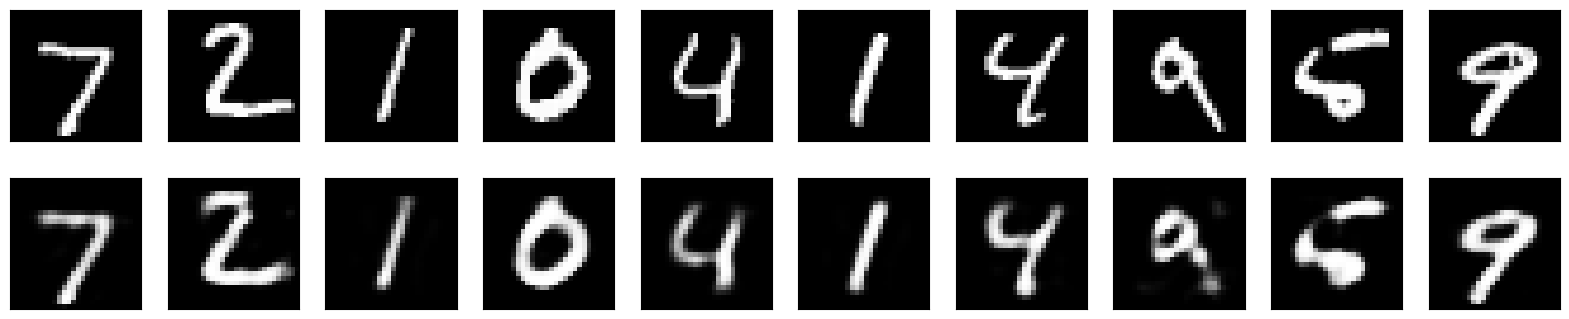

In [20]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.



### Adding a sparsity constraint on the encoded representations

In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:



In [38]:
from keras import regularizers

encoding_dim = 32

input_img = keras.Input(shape=(784,))

# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [39]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's train this model for 100 epochs (with the added regularization the model is less likely to overfit and can be trained longer). The models ends with a train loss of 0.11 and test loss of 0.10. The difference between the two is mostly due to the regularization term being added to the loss during training (worth about 0.01).

In [40]:
autoencoder.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 3ms/step - loss: 0.2900 - val_loss: 0.2002
Epoch 2/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1790 - val_loss: 0.1613
Epoch 3/100
235/235 [==============================] - 1s 2ms/step - loss: 0.1526 - val_loss: 0.1426
Epoch 4/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1377 - val_loss: 0.1308
Epoch 5/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1281 - val_loss: 0.1228
Epoch 6/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1214 - val_loss: 0.1174
Epoch 7/100
235/235 [==============================] - 1s 3ms/step - loss: 0.1168 - val_loss: 0.1135
Epoch 8/100
235/235 [==============================] - 1s 2ms/step - loss: 0.1134 - val_loss: 0.1107
Epoch 9/100
235/235 [==============================] - 1s 2ms/step - loss: 0.1109 - val_loss: 0.1085
Epoch 10/100
235/235 [==============================] - 1s 2ms/step - loss: 0.1091 - val_lo

In [41]:
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [42]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 257us/step


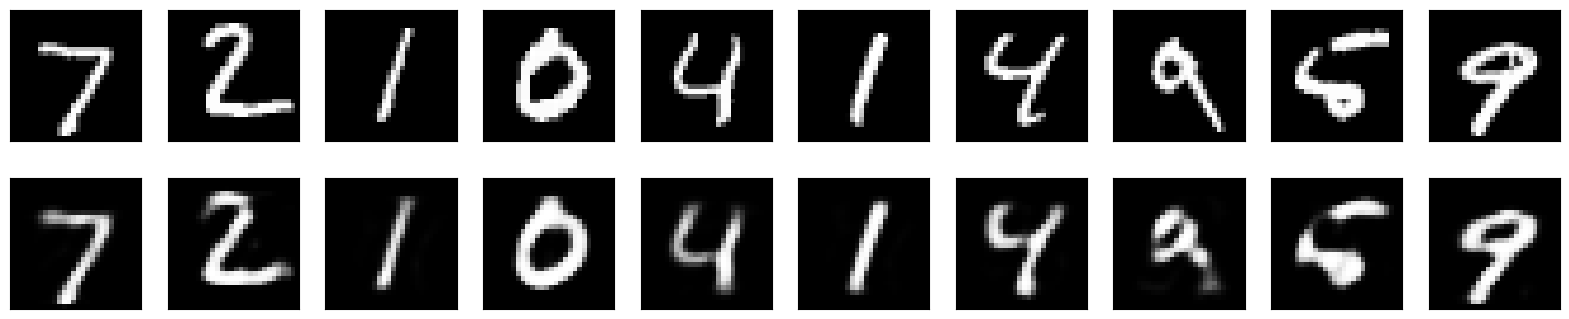

In [43]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

They look pretty similar to the previous model, the only significant difference being the sparsity of the encoded representations. encoded_imgs.mean() yields a value 3.33 (over our 10,000 test images), whereas with the previous model the same quantity was 7.30. So our new model yields encoded representations that are twice sparser.

### Deep Autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:

In [44]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

In [45]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
235/235 [==============================] - 1s 4ms/step - loss: 0.2476 - val_loss: 0.1687
Epoch 2/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1522 - val_loss: 0.1368
Epoch 3/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1308 - val_loss: 0.1230
Epoch 4/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1212 - val_loss: 0.1169
Epoch 5/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1161 - val_loss: 0.1126
Epoch 6/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1124 - val_loss: 0.1093
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1095 - val_loss: 0.1066
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1066 - val_loss: 0.1038
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1043 - val_loss: 0.1024
Epoch 10/100
235/235 [==============================] - 1s 4ms/step - loss: 0.1022 - val_lo

After 100 epochs, it reaches a train and validation loss of ~0.08, a bit better than our previous models. Our reconstructed digits look a bit better too:

In [58]:
predicted_values = autoencoder.predict(x_test)

313/313 [==============================] - 0s 476us/step


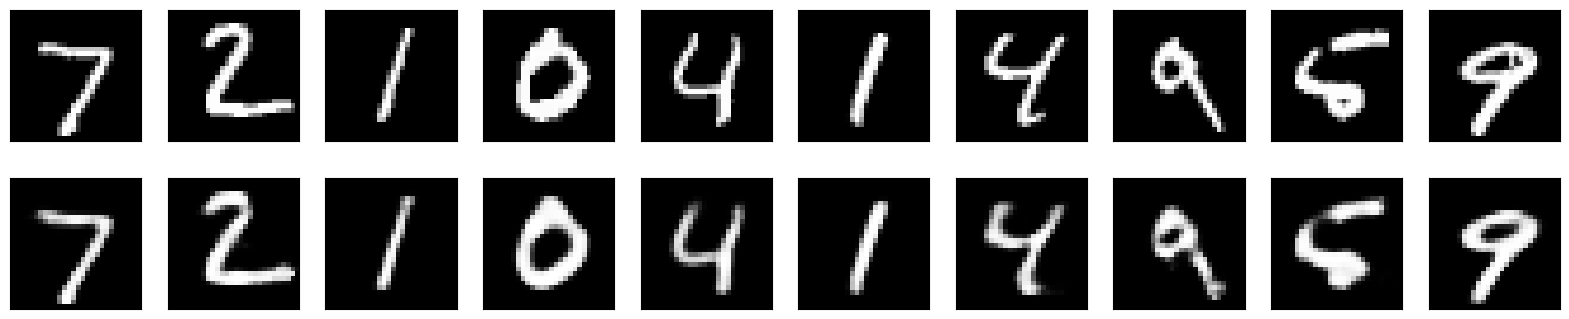

In [59]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_values[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers

In [61]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.


In [62]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.



Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server.



In [64]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=[TensorBoard(log_dir = '/tmp/autoencoder')])

Epoch 1/50
469/469 [==============================] - 11s 23ms/step - loss: 0.2172 - val_loss: 0.1423
Epoch 2/50
469/469 [==============================] - 11s 23ms/step - loss: 0.1319 - val_loss: 0.1225
Epoch 3/50
469/469 [==============================] - 11s 23ms/step - loss: 0.1194 - val_loss: 0.1148
Epoch 4/50
469/469 [==============================] - 11s 23ms/step - loss: 0.1135 - val_loss: 0.1098
Epoch 5/50
469/469 [==============================] - 11s 24ms/step - loss: 0.1093 - val_loss: 0.1066
Epoch 6/50
469/469 [==============================] - 11s 24ms/step - loss: 0.1065 - val_loss: 0.1041
Epoch 7/50
469/469 [==============================] - 11s 23ms/step - loss: 0.1043 - val_loss: 0.1021
Epoch 8/50
469/469 [==============================] - 11s 22ms/step - loss: 0.1026 - val_loss: 0.1008
Epoch 9/50
469/469 [==============================] - 11s 22ms/step - loss: 0.1013 - val_loss: 0.0998
Epoch 10/50
469/469 [==============================] - 11s 23ms/step - loss: 0.100

The model converges to a loss of 0.09, significantly better than our previous models (this is in large part due to the higher entropic capacity of the encoded representation, 128 dimensions vs. 32 previously). Let's take a look at the reconstructed digits:



313/313 [==============================] - 1s 2ms/step


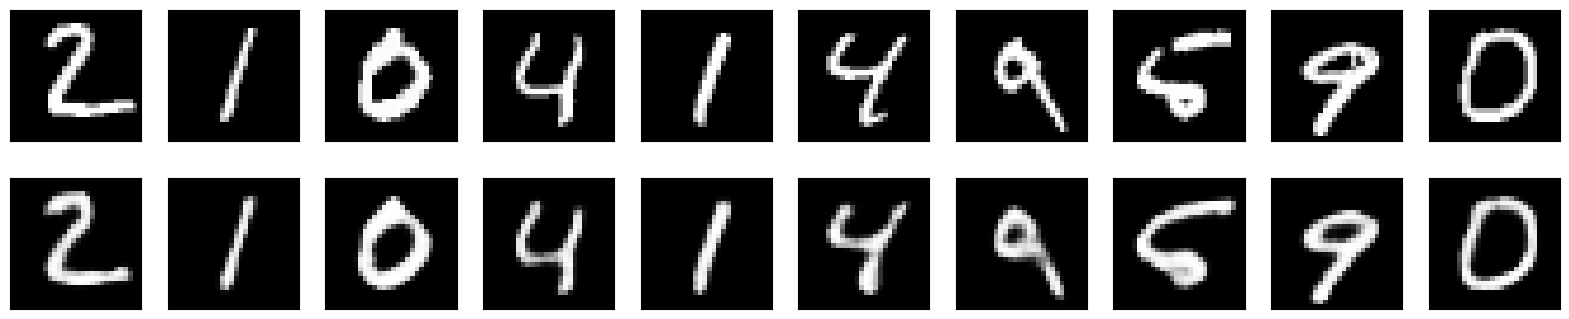

In [65]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()